In [2]:
import os
import numpy as np
import mne
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

def load_eeg_data(base_path, target_length=2000, target_channels=19):
    data = []
    labels = []

    print("Processing EEG data...")

    for node_folder in os.listdir(base_path):  # Iterate through each 'node' folder
        node_path = os.path.join(base_path, node_folder)
        if os.path.isdir(node_path) and node_folder.startswith("node"):  # Ensure it's a node folder
            for subset_folder in os.listdir(node_path):  # Iterate through 'subset_1', 'subset_2', etc.
                subset_path = os.path.join(node_path, subset_folder)
                if os.path.isdir(subset_path) and subset_folder.startswith("subset"):  # Ensure it's a subset folder
                    for subject_folder in os.listdir(subset_path):  # Iterate through each 'subject_X' folder
                        subject_path = os.path.join(subset_path, subject_folder)
                        if os.path.isdir(subject_path) and subject_folder.startswith("subject"):  # Ensure it's a subject folder
                            try:
                                # Extract subject ID from the folder name
                                folder_name = os.path.basename(subject_path)
                                subject_id = int(folder_name.split('_')[-1])  # Extract subject ID after 'subject_'
                                print(f"Extracted subject_id: {subject_id}")  # Debugging: print subject ID

                                # Check for userfile.gnr in the current folder
                                userfile_path = os.path.join(subject_path, 'userfile.gnr')
                                if os.path.exists(userfile_path):
                                    with open(userfile_path, 'r') as file:
                                        category = None
                                        for line in file:
                                            if "category" in line.lower():
                                                category = line.strip().split('=')[-1].strip()
                                                break
                                        if category.lower() == "patient":
                                            label = 1  # Schizophrenia patients
                                        elif category.lower() == "control":
                                            label = 0  # Healthy controls
                                        else:
                                            print(f"Warning: Category not found for subject_{subject_id}. Skipping.")
                                            continue
                                else:
                                    print(f"Warning: userfile.gnr not found for subject_{subject_id}. Skipping.")
                                    continue

                                print(f"Assigned label: {label}")  # Debugging: print assigned label

                                # Process each folder (e.g., 1, 2, 3) inside the subject folder
                                for subfolder in os.listdir(subject_path):  # Check subfolders 1, 2, 3, etc.
                                    subfolder_path = os.path.join(subject_path, subfolder)
                                    if os.path.isdir(subfolder_path) and subfolder.isdigit():  # Ensure it's a valid subfolder (e.g., 1, 2, 3)
                                        for file in os.listdir(subfolder_path):
                                            if file.endswith('.edf'):
                                                file_path = os.path.join(subfolder_path, file)
                                                try:
                                                    raw = mne.io.read_raw_edf(file_path, preload=True)
                                                    raw.filter(1, 40, fir_design='firwin')

                                                    eeg_data = raw.get_data()
                                                    num_channels = eeg_data.shape[0]

                                                    # Handle unexpected channel numbers (truncating or padding to 19)
                                                    if num_channels < target_channels:
                                                        padding = target_channels - num_channels
                                                        eeg_data = np.pad(eeg_data, ((0, 0), (0, padding)), mode='constant', constant_values=0)
                                                    elif num_channels > target_channels:
                                                        eeg_data = eeg_data[:target_channels, :]
                                                    
                                                    # Adjust data length to match the target length
                                                    if eeg_data.shape[1] < target_length:
                                                        padding = target_length - eeg_data.shape[1]
                                                        eeg_data = np.pad(eeg_data, ((0, 0), (0, padding)), mode='constant', constant_values=0)
                                                    elif eeg_data.shape[1] > target_length:
                                                        eeg_data = eeg_data[:, :target_length]

                                                    data.append(eeg_data)
                                                    labels.append(label)

                                                except Exception as e:
                                                    print(f"Error processing file {file}: {e}")

                            except Exception as e:
                                print(f"Error processing folder {subject_path}: {e}")

    if not data or not labels:
        raise ValueError("No valid EEG data loaded. Please check the dataset and processing steps.")

    # Print final label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Final label distribution: {dict(zip(unique, counts))}")  # Debugging: print final label distribution

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.int32)


# Function to extract features from EEG data
def extract_features(eeg_data):
    features = []
    for sample in eeg_data:
        feature_vector = []
        for channel in sample:
            # Temporal domain features
            feature_vector.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                np.var(channel),
                np.ptp(channel),  # Peak-to-peak range
            ])

            # Frequency domain features (FFT)
            fft_vals = np.abs(np.fft.fft(channel))[:len(channel) // 2]
            feature_vector.extend([
                np.mean(fft_vals),
                np.std(fft_vals),
                np.max(fft_vals),
                np.sum(fft_vals)  # Total spectral power
            ])
        features.append(feature_vector)
    return np.array(features)

# Main execution
if __name__ == "__main__":
    # Define base path to EEG data
    base_path = "C:\\Users\\tanis\\Downloads\\ASZED-153\\ASZED\\version_1.1"  # Update with your path

    try:
        # Load EEG data
        raw_data, raw_labels = load_eeg_data(base_path)
        print(f"Raw data shape: {raw_data.shape}")
        print(f"Raw labels shape: {raw_labels.shape}")

        # Check label distribution before processing
        unique, counts = np.unique(raw_labels, return_counts=True)
        print(f"Label distribution before any processing: {dict(zip(unique, counts))}")

        # Ensure that both classes are present in the dataset
        if len(counts) < 2:
            raise ValueError("Dataset contains only one class. Please check label assignment.")

        # Extract features from the raw data
        features = extract_features(raw_data)
        print(f"Feature shape: {features.shape}")

        # Normalize the features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Split data into training and testing sets with stratified sampling
        X_train, X_test, y_train, y_test = train_test_split(
            features, raw_labels, test_size=0.2, random_state=42, stratify=raw_labels
        )

        # Check the class distribution in the split data
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        print(f"Train class distribution: {dict(zip(unique_train, counts_train))}")
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        print(f"Test class distribution: {dict(zip(unique_test, counts_test))}")

        # Apply SMOTE to handle class imbalance
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        print(f"Train class distribution after SMOTE: {np.bincount(y_train_smote)}")

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'kernel': ['linear', 'rbf']
        }
        grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train_smote, y_train_smote)
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

        # Train SVM model with the best parameters
        svm_model = grid_search.best_estimator_

        # Evaluate using cross-validation
        cv_scores = cross_val_score(svm_model, X_train_smote, y_train_smote, cv=5)
        print(f"Cross-validation accuracy scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean()}")

        # Predict on the test set
        y_pred = svm_model.predict(X_test)

        # Evaluate the model
        print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Classification report:\n{classification_report(y_test, y_pred)}")
        print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

    except Exception as e:
        print(f"Error: {e}")


Processing EEG data...
Extracted subject_id: 10
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 11
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 12
As

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 13
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 14
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracted subject_id: 15
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 17
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 18
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 19
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\1\Phase 3.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 3.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\3\Phase 1.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 21
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 22
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\3\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 23
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\2\Phase 1.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 24
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\1\Phase 3.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 26
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 27
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracted subject_id: 28
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 29
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\2\Phase 3.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\3\Phase 1.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 30
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 33
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    14.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\2\Phase 1.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    14.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    14.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\5\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\5\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 4399  =      0.000 ...    21.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\6\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\7\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\7\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\8\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\8\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\8\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 34
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 36
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 1.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 37
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\2\Phase 1.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\3\Phase 1.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 39
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\1\Phase 3.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    29.990 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 41
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 46
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\2\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 47
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 48
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 49
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 5
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 1.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23999  =      0.000 ...   119.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\2\Phase 3.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 51
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 54
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 55
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering r

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 56
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\2\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 58
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\3\Phase 3.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 59
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 6
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 1.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 3.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\2\Phase 2.edf...
EDF file

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\2\Phase 4.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 60
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 2.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 62
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_63\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_63\1\Phase 2.edf...
EDF file detected
Setting ch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_63\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 64
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 67
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\1\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 68
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\2\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 7
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 4.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\1\Phase 2.edf...
EDF file detected
Setting c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 2.edf...
EDF file detected
Setting c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 72
As

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\1\Phase 3.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 73
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 74
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\1\Phase 1.edf...
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\2\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 3.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\2\Phase 1.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 9
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\1\Phase 2.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\2\Phase 1.edf...
EDF file detected
Setting channel info structure

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_100\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 101
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_101\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_101\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 102
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 5.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 103
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6911  =      0.000 ...    26.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domai

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 107
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\1\Phase 3.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 111
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\2\Phase 1.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\1\Phase 5.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 115
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\4\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 119
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 120
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 122
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 123
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracted subject_id: 125
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\1\Phase 2.edf..

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 126
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracted subject_id: 127
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\1\Phase 2.edf..

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\2\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 3.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 130
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 132
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 3.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 135
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\4\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\5\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\5\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 140
Assigned label: 0
Extracting EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 141
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 142
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domai

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 151
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 152
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 155
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 3.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 156
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 157
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\A

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domai

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 1.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 158
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 4.edf...
EDF file detected
Setting channel info st

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 159
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\3\Phase 3.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 160
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 4.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 5.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 79
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 2.edf...
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 4.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 5.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 82
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6143  =      0.000 ...    23.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 4.edf...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 83
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwid

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 4.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\3\Phase 1.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 86
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 87
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 2.edf...
EDF file detected
Setting c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 4.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracted subject_id: 89
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 5.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 90
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 4.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\3\Phase 4.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 91
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 93
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\1\Phase 3.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 4.edf...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 99
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 2.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 4.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 100
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 101
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 102
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 5.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 106
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\2\Phase 1.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4863  =      0.000 ...    18.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 108
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 110
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_110\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_110\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_110\2\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_110\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 111
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 120
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 121
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_121\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_121\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 123
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_123\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_123\3\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_123\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_123\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 133
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_133\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_133\3\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 134
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 136
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_136\3\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_136\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 137
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 140
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 5.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2559  =      0.000 ...     9.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\2\Phase 5.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\tanis\AppData\Local\Temp\ipykernel_15052\4121457391.py:62: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(1, 40, fir_design='firwin')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_148\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_148\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 149
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\2\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 150
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 151
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_151\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 156
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 160
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 93
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_93\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 95
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 96
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Raw data shape: (1932, 19, 2000)
Raw labels shape: (1932,)
Label distribution before any processing: {0: 991, 1: 941}
Feature shape: (1932, 209)
Train class distribution: {0: 792, 1: 753}
Test class distribution: {0: 199, 1: 188}
Train class distribution after SMOTE: [792 792]
Best parameters from GridSearchCV: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-validation accuracy scores: [0.84542587 0.829653   0.82018927 0.87066246 0.82594937]
Mean CV accuracy: 0.8383759932915386
Test accuracy: 0.8475452196382429
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       199
           1       0.83      0.86      0.85       188

    accuracy                           0.85       387
   macro avg       0.85      0.85      0.85       387
weighted avg       0.85      0.85      0.85       387

Confusion matrix:
[[167  32]
 [ 27 161]]


In [3]:
import os
import numpy as np
import mne
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def load_eeg_data(base_path, target_length=2000, target_channels=19):
    data = []
    labels = []

    print("Processing EEG data...")

    for node_folder in os.listdir(base_path):  # Iterate through each 'node' folder
        node_path = os.path.join(base_path, node_folder)
        if os.path.isdir(node_path) and node_folder.startswith("node"):  # Ensure it's a node folder
            for subset_folder in os.listdir(node_path):  # Iterate through 'subset_1', 'subset_2', etc.
                subset_path = os.path.join(node_path, subset_folder)
                if os.path.isdir(subset_path) and subset_folder.startswith("subset"):  # Ensure it's a subset folder
                    for subject_folder in os.listdir(subset_path):  # Iterate through each 'subject_X' folder
                        subject_path = os.path.join(subset_path, subject_folder)
                        if os.path.isdir(subject_path) and subject_folder.startswith("subject"):  # Ensure it's a subject folder
                            try:
                                # Extract subject ID from the folder name
                                folder_name = os.path.basename(subject_path)
                                subject_id = int(folder_name.split('_')[-1])  # Extract subject ID after 'subject_'
                                print(f"Extracted subject_id: {subject_id}")  # Debugging: print subject ID

                                # Check for userfile.gnr in the current folder
                                userfile_path = os.path.join(subject_path, 'userfile.gnr')
                                if os.path.exists(userfile_path):
                                    with open(userfile_path, 'r') as file:
                                        category = None
                                        for line in file:
                                            if "category" in line.lower():
                                                category = line.strip().split('=')[-1].strip()
                                                break
                                        if category.lower() == "patient":
                                            label = 1  # Schizophrenia patients
                                        elif category.lower() == "control":
                                            label = 0  # Healthy controls
                                        else:
                                            print(f"Warning: Category not found for subject_{subject_id}. Skipping.")
                                            continue
                                else:
                                    print(f"Warning: userfile.gnr not found for subject_{subject_id}. Skipping.")
                                    continue

                                print(f"Assigned label: {label}")  # Debugging: print assigned label

                                # Process each folder (e.g., 1, 2, 3) inside the subject folder
                                for subfolder in os.listdir(subject_path):  # Check subfolders 1, 2, 3, etc.
                                    subfolder_path = os.path.join(subject_path, subfolder)
                                    if os.path.isdir(subfolder_path) and subfolder.isdigit():  # Ensure it's a valid subfolder (e.g., 1, 2, 3)
                                        for file in os.listdir(subfolder_path):
                                            if file.endswith('.edf'):
                                                file_path = os.path.join(subfolder_path, file)
                                                try:
                                                    raw = mne.io.read_raw_edf(file_path, preload=True)
                                                    raw.filter(1, 40, fir_design='firwin')

                                                    eeg_data = raw.get_data()
                                                    num_channels = eeg_data.shape[0]

                                                    # Handle unexpected channel numbers (truncating or padding to 19)
                                                    if num_channels < target_channels:
                                                        padding = target_channels - num_channels
                                                        eeg_data = np.pad(eeg_data, ((0, 0), (0, padding)), mode='constant', constant_values=0)
                                                    elif num_channels > target_channels:
                                                        eeg_data = eeg_data[:target_channels, :]
                                                    
                                                    # Adjust data length to match the target length
                                                    if eeg_data.shape[1] < target_length:
                                                        padding = target_length - eeg_data.shape[1]
                                                        eeg_data = np.pad(eeg_data, ((0, 0), (0, padding)), mode='constant', constant_values=0)
                                                    elif eeg_data.shape[1] > target_length:
                                                        eeg_data = eeg_data[:, :target_length]

                                                    data.append(eeg_data)
                                                    labels.append(label)

                                                except Exception as e:
                                                    print(f"Error processing file {file}: {e}")

                            except Exception as e:
                                print(f"Error processing folder {subject_path}: {e}")

    if not data or not labels:
        raise ValueError("No valid EEG data loaded. Please check the dataset and processing steps.")

    # Print final label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Final label distribution: {dict(zip(unique, counts))}")  # Debugging: print final label distribution

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.int32)


# Function to extract features from EEG data
def extract_features(eeg_data):
    features = []
    for sample in eeg_data:
        feature_vector = []
        for channel in sample:
            # Temporal domain features
            feature_vector.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                np.var(channel),
                np.ptp(channel),  # Peak-to-peak range
            ])

            # Frequency domain features (FFT)
            fft_vals = np.abs(np.fft.fft(channel))[:len(channel) // 2]
            feature_vector.extend([
                np.mean(fft_vals),
                np.std(fft_vals),
                np.max(fft_vals),
                np.sum(fft_vals)  # Total spectral power
            ])
        features.append(feature_vector)
    return np.array(features)

# Main execution
if __name__ == "__main__":
    # Define base path to EEG data
    base_path = "C:\\Users\\tanis\\Downloads\\ASZED-153\\ASZED\\version_1.1"  # Update with your path

    try:
        # Load EEG data
        raw_data, raw_labels = load_eeg_data(base_path)
        print(f"Raw data shape: {raw_data.shape}")
        print(f"Raw labels shape: {raw_labels.shape}")

        # Check label distribution before processing
        unique, counts = np.unique(raw_labels, return_counts=True)
        print(f"Label distribution before any processing: {dict(zip(unique, counts))}")

        # Ensure that both classes are present in the dataset
        if len(counts) < 2:
            raise ValueError("Dataset contains only one class. Please check label assignment.")

        # Extract features from the raw data
        features = extract_features(raw_data)
        print(f"Feature shape: {features.shape}")

        # Normalize the features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Split data into training and testing sets with stratified sampling
        X_train, X_test, y_train, y_test = train_test_split(
            features, raw_labels, test_size=0.2, random_state=42, stratify=raw_labels
        )

        # Check the class distribution in the split data
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        print(f"Train class distribution: {dict(zip(unique_train, counts_train))}")
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        print(f"Test class distribution: {dict(zip(unique_test, counts_test))}")

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced']  # Added class_weight for imbalance handling
        }
        grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

        # Train SVM model with the best parameters
        svm_model = grid_search.best_estimator_

        # Evaluate using cross-validation
        cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
        print(f"Cross-validation accuracy scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean()}")

        # Predict on the test set
        y_pred = svm_model.predict(X_test)

        # Evaluate the model
        print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Classification report:\n{classification_report(y_test, y_pred)}")
        print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

    except Exception as e:
        print(f"Error: {e}")


Processing EEG data...
Extracted subject_id: 10
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_10\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 11
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_11\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 12
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_12\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 13
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_13\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 14
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_14\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 15
As

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_15\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 16
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_16\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_17\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_18\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 19
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_19\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 2
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 sampl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    29.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 2.edf...
EDF fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    29.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_2\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 20
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_20\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 21
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_21\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 22
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_22\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 23
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_23\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 24
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_24\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 25
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_25\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 26
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering r

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_26\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 27
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_27\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracted subject_id: 28
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_28\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_29\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 2999  =      0.000 ...    29.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_3\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_30\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 31
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 2.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_31\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 33
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\1\Phase 4.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    14.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\5\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\5\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\5\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\6\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\6\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4399  =      0.000 ...    21.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\6\Phase 3.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\6\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\7\Phase 1.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\7\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\8\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_33\8\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 34
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_34\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\1\Phase 2.edf...
EDF file detected
Setting c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_35\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 36
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_36\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FI

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_37\4\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 38
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_38\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 39
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_39\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    39.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    59.990 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999  =      0.000 ...    29.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\2\Phase 4.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_4\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_40\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_41\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_42\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 43
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_43\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 44
As

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_44\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 45
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering r

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_45\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 46
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_46\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 47
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_47\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_48\3\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_49\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 5
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 2.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 23999  =      0.000 ...   119.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_5\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 50
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_50\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 51
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_51\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 52
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\3\Phase 1.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_52\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 53
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\1\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_53\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 54
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_54\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 55
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_55\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 56
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_56\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 57
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_57\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_58\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 59
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_59\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 6
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 1.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\1\Phase 3.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_6\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 60
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_60\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_61\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 62
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 2.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\2\Phase 4.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_62\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 63
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_63\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4199  =      0.000 ...    20.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_63\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 64
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\1\Phase 2.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999  =      0.000 ...    19.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_64\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 65
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\2\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_65\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_66\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 1.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_67\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 68
As

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\2\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_68\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 7999  =      0.000 ...    39.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 69
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_69\3\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 7
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\1\Phase 2.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\1\Phase 4.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 2.edf...
EDF file detected
Setting channel info structure

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_7\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_70\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_71\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_72\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\4\Phase 1.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_73\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 74
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_74\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 75
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 1.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_75\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 76
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
S

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_76\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 77
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_77\3\Phase 3.edf...
EDF file detected
Setting channel info struc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 78
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\1\Phase 4.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999  =      0.000 ...     9.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\4\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_78\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6999  =      0.000 ...    34.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 8
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 1.edf...
EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 3.edf...
EDF file detected
Setting channel info structu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\2\Phase 1.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_8\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 9
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\1\Phase 2.edf...
EDF fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     4.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_1\subject_9\2\Phase 2.edf...
EDF file detected
Setting channel info structure

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)

Extracted subject_id: 100
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_100\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_100\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 101
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_101\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_101\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_101\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 102
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_102\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 103
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6911  =      0.000 ...    26.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_103\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_104\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_107\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 109
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_109\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_110\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_111\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\1\Phase 5.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_112\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_113\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\3\Phase 1.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_114\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 115
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\4\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_115\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 116
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_116\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_117\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\4\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_118\4\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 119
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\3\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_119\4\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 120
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_120\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 121
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_121\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 2.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_122\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_123\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_124\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_125\4\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 126
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_126\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 127
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_127\4\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 128
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_128\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 129
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_129\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 130
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_130\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 131
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_131\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 132
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_132\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_133\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\2\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\4\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_134\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 135
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\5\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\5\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\5\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_135\6\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 136
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\1\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_136\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_139\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 2.edf...
EDF file detected
Setting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_140\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_141\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_142\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 147
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\2\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_147\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 148
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 1.edf..

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_148\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 151
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 1.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_151\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 152
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_152\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\AS

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_153\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 154
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\1\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_154\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_155\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_156\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_157\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 158
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\2\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_158\3\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 159
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_159\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 1.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_160\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 79
Assigned label: 0
Extracting EDF 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_79\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 80
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_80\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_81\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6143  =      0.000 ...    23.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_82\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_83\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_84\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_85\4\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 86
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_86\4\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 87
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_87\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 88
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 2.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\1\Phase 5.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_88\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_89\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_90\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 91
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 2.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_91\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_92\3\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\1\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_93\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\3\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_94\4\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 1.edf...
EDF f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_95\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 96
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_96\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_97\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 98
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\2\Phase 1.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_98\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 99
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\1\Phase 1.edf...
ED

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_2\subject_99\2\Phase 5.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 100
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_100\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_101\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 102
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_102\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_103\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 3.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4351  =      0.000 ...    16.996 secs...
Filtering raw data in 1 contiguous segment
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4863  =      0.000 ...    18.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\3\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3071  =      0.000 ...    11.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_106\4\Phase 5.edf...
EDF

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 108
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_108\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_110\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 111
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_111\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 120
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_120\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 121
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_121\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_121\4\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_121\4\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_123\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8191  =      0.000 ...    31.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 133
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_133\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.99

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_134\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_136\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 137
Assigned label: 1
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_137\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 140
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.9

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_140\2\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\2\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

C:\Users\tanis\AppData\Local\Temp\ipykernel_15052\291332839.py:61: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(1, 40, fir_design='firwin')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\3\Phase 4.edf...
EDF file detected
Setting channel info str

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...    61.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\4\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_145\5\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracted subject_id: 147
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 2.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_147\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_148\1\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_148\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_148\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 149
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\1\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_149\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 150
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\2\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_150\2\Phase 2.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_151\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 156
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 1.edf...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_156\1\Phase 4.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 160
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_160\1\Phase 5.edf...
EDF file detected
Setting channel info stru

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_93\3\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 3.edf...
EDF file detected
Setting channel info struct

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_95\2\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracted subject_id: 96
Assigned label: 0
Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1791  =      0.000 ...     6.996 secs...
Filtering raw data in 1 contiguous 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\tanis\Downloads\ASZED-153\ASZED\version_1.1\node_1\subset_3\subject_96\3\Phase 5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1023  =      0.000 ...     3.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Final label distribution: {0: 991, 1: 941}


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Raw data shape: (1932, 19, 2000)
Raw labels shape: (1932,)
Label distribution before any processing: {0: 991, 1: 941}
Feature shape: (1932, 209)
Train class distribution: {0: 792, 1: 753}
Test class distribution: {0: 199, 1: 188}
Best parameters from GridSearchCV: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Cross-validation accuracy scores: [0.84789644 0.82847896 0.81229773 0.86731392 0.8381877 ]
Mean CV accuracy: 0.8388349514563107
Test accuracy: 0.8475452196382429
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       199
           1       0.83      0.86      0.85       188

    accuracy                           0.85       387
   macro avg       0.85      0.85      0.85       387
weighted avg       0.85      0.85      0.85       387

Confusion matrix:
[[167  32]
 [ 27 161]]


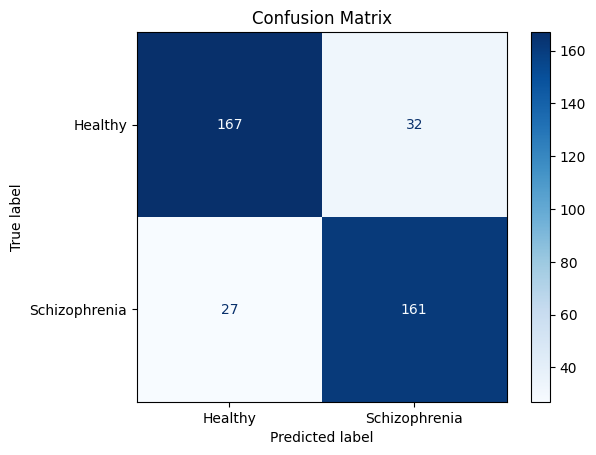

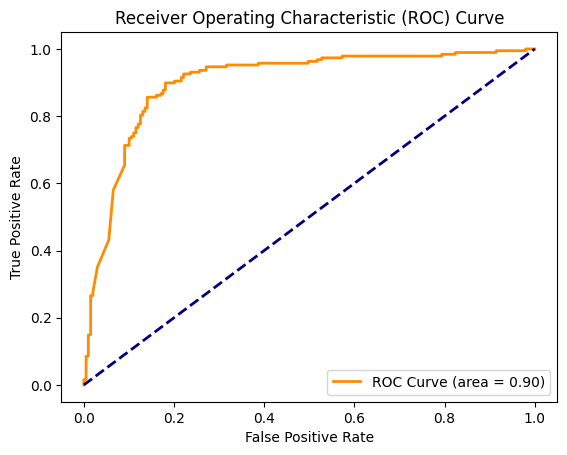

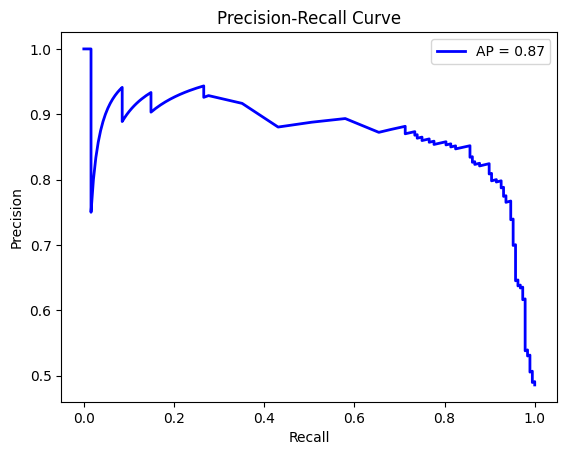

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score

# Confusion Matrix
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Healthy", "Schizophrenia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_score = svm_model.decision_function(X_test)  # Decision function scores for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
avg_precision = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()


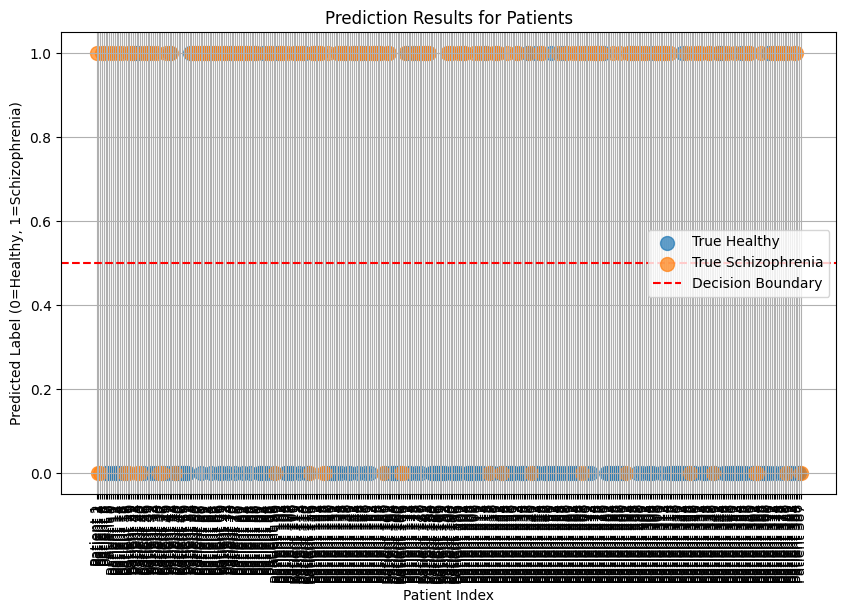

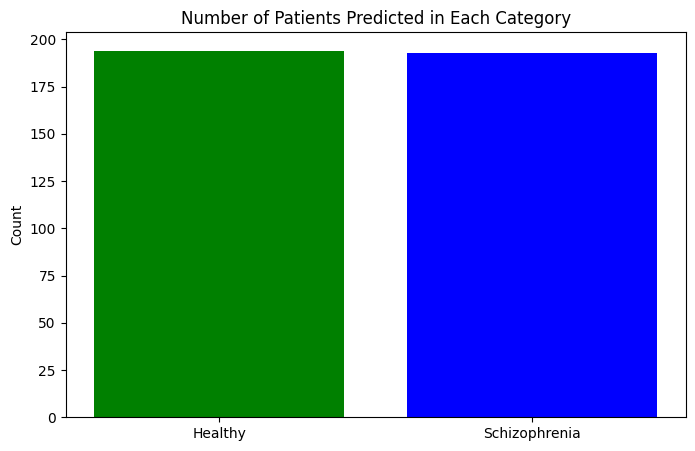

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for test data
y_pred = svm_model.predict(X_test)

# Map predictions to labels
predicted_labels = ["Schizophrenia" if pred == 1 else "Healthy" for pred in y_pred]
actual_labels = ["Schizophrenia" if actual == 1 else "Healthy" for actual in y_test]

# Create indices for patients
patient_indices = np.arange(len(y_test))

# Scatter plot to visualize predictions
plt.figure(figsize=(10, 6))
for i, label in enumerate(["Healthy", "Schizophrenia"]):
    indices = [j for j, true_label in enumerate(actual_labels) if true_label == label]
    plt.scatter(
        patient_indices[indices],
        y_pred[indices],
        label=f"True {label}",
        alpha=0.7,
        s=100,
    )

plt.axhline(0.5, color="red", linestyle="--", label="Decision Boundary")
plt.xlabel("Patient Index")
plt.ylabel("Predicted Label (0=Healthy, 1=Schizophrenia)")
plt.title("Prediction Results for Patients")
plt.xticks(ticks=patient_indices, labels=[f"Patient {i+1}" for i in patient_indices], rotation=90)
plt.legend()
plt.grid(True)
plt.show()

# Summary Bar Chart
results = {"Healthy": sum(y_pred == 0), "Schizophrenia": sum(y_pred == 1)}

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=["green", "blue"])
plt.title("Number of Patients Predicted in Each Category")
plt.ylabel("Count")
plt.show()


In [6]:
import joblib
joblib.dump(svm_model, 'svm_model.pkl')


['svm_model.pkl']

In [7]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']